<h1>Проект: анализ продуктовых метрик сервиса по доставке продуктов<h1>

__Условие:__

Вы работаете продуктовым аналитиком в компании по доставке продуктов на дом. Сервис доступен как в приложении на ios, так и на android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. 

Вы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020, только по пользователям, зарегистрированным позднее 1 января 2020.

Испортируем необходимые библиотеки

In [18]:
import pandas as pd
import seaborn as sns
import datetime
import requests
from urllib.parse import urlencode

Подгружаем данные с Яндекс.Диска

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/p_UjGG_Dv8CE5Q'  # Сюда вписываете вашу ссылку

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('case_data.csv', 'wb') as f:   # Здесь укажите нужный путь к файлу
        f.write(download_response.content)

In [3]:
case_data = pd.read_csv('case_data.csv', encoding='utf-8', sep=',')
case_data

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads
...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads


Проведем предварительную проверку данных

In [4]:
# пропущенные значения
case_data.isna().sum()

date                  0
event                 0
purchase_sum    2606585
os_name               0
device_id             0
gender                0
city                  0
utm_source            0
dtype: int64

In [5]:
# типы данных в колонках
case_data.dtypes

date             object
event            object
purchase_sum    float64
os_name          object
device_id         int64
gender           object
city             object
utm_source       object
dtype: object

In [6]:
# перевод в формат даты
case_data.date = pd.to_datetime(case_data.date)

In [7]:
# уникальные значения
case_data.nunique()

date                91
event                7
purchase_sum      8775
os_name              2
device_id       190884
gender               2
city                 2
utm_source           7
dtype: int64

In [8]:
# разброс дат
case_data.date.agg(['min', 'max'])

min   2020-01-01
max   2020-03-31
Name: date, dtype: datetime64[ns]

<h2>Задание 1<h2>

Необходимо найти __MAU__ февраля

In [9]:
MAU_feb = case_data.query("date.dt.month == 2").device_id.nunique()
MAU_feb

75032

<h2>Задание 2<h2>

Необходимо найти __количество установок__ в Январе

In [10]:
inst_jan = case_data \
    .query("date.dt.month == 1 & event == 'app_install'").device_id.nunique()
inst_jan

80297

<h2>Задание 3<h2>

Присвойте пользователям когорты по дню установки приложения и посчитайте для них  __Conversion Rate__ из установки в покупку в течение 7 дней. Для какой когорты конверсия была наибольшей?

Примечание: считаем пользователя сконвертировавшимся, если с момента установки до совершения первой покупки прошло не более 7 дней.

In [11]:
# определим кагорты по дню установки
installs = case_data.query('event == "app_install"')[['date', 'device_id']]
installs = installs.drop_duplicates('device_id') \
    .rename(columns={'date': 'install_date'})
installs.head()

,install_date,device_id
2515061,2020-01-01,4921563
2515062,2020-01-01,1311583
2515063,2020-01-01,23006325
2515064,2020-01-01,5645652
2515065,2020-01-01,8798567


In [12]:
# добавляем новый столбик с когортами установки в основной датафрейм
case_data_merged = case_data.merge(installs, how='left', on='device_id') \
    .rename(columns={'date_x': 'date', 'date_y': 'install_date'})
case_data_merged

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,install_date
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-01
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,NaT
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01-01
...,...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads,2020-03-28
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-,2020-03-31
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads,2020-03-31
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads,2020-03-06


In [13]:
# определим кагорты по дню покупки
purchases = case_data.query('event == "purchase"')[['date', 'device_id']]
purchases = purchases.sort_values(by='date') \
    .drop_duplicates('device_id').rename(columns={'date': 'purchase_date'})
purchases.head()

,purchase_date,device_id
7691,2020-01-01,6081155
8289,2020-01-01,1955306
8290,2020-01-01,20176327
8291,2020-01-01,28603960
8292,2020-01-01,14028316


In [14]:
# добавляем новый столбик с когортами покупки в основной датафрейм
case_data_merged = case_data_merged \
    .merge(purchases, how='left', on='device_id')
case_data_merged.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,install_date,purchase_date
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-01,2020-01-07
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01,2020-01-01
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,NaT,2020-01-01
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01,NaT
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01-01,NaT


In [15]:
# в отдельный столбик вынесем разницу в днях между установкой и датой покупки
case_data_merged['days'] = case_data_merged.purchase_date - \
    case_data_merged.install_date

In [16]:
# считаем уникальных пользователей в день установки
instals_on_date = case_data_merged \
    .query("event == 'app_install'") \
    .groupby('install_date', as_index=False) \
    .agg({'device_id': 'nunique'}) \
    .rename(columns={'device_id': 'users_inst'})
instals_on_date

,install_date,users_inst
0,2020-01-01,3579
1,2020-01-02,3144
2,2020-01-03,2402
3,2020-01-04,1831
4,2020-01-05,1671
...,...,...
86,2020-03-27,1199
87,2020-03-28,1091
88,2020-03-29,1117
89,2020-03-30,994


In [19]:
# считаем уникальных пользователей в день покупки
purchases_on_date = case_data_merged \
    .query("event == 'purchase' & days < datetime.timedelta(days=8)") \
    .groupby('install_date', as_index=False) \
    .agg({'device_id': 'nunique'}) \
    .rename(columns={'device_id': 'users_purch'})
purchases_on_date

,install_date,users_purch
0,2020-01-01,1408
1,2020-01-02,1186
2,2020-01-03,834
3,2020-01-04,639
4,2020-01-05,587
...,...,...
86,2020-03-27,277
87,2020-03-28,209
88,2020-03-29,223
89,2020-03-30,204


In [20]:
# считаем CR
instals_on_date['users_purch'] = purchases_on_date.users_purch
instals_on_date['CR'] = round(
    (instals_on_date.users_purch / instals_on_date.users_inst)*100, 2)
instals_on_date.sort_values('CR', ascending=False)

,install_date,users_inst,users_purch,CR
0,2020-01-01,3579,1408,39.34
8,2020-01-09,1424,558,39.19
14,2020-01-15,4310,1650,38.28
13,2020-01-14,5173,1973,38.14
1,2020-01-02,3144,1186,37.72
...,...,...,...,...
77,2020-03-18,1171,235,20.07
88,2020-03-29,1117,223,19.96
81,2020-03-22,1261,251,19.90
87,2020-03-28,1091,209,19.16


__Ответ:__ Для когорты "2020-01-01" конверсия была наибольшей и составила 39.34%

<h2>Задание 4<h2>

С какого платного маркетингового канала пришло больше всего новых пользователей? 

In [21]:
case_data.query("event == 'app_install' & utm_source != '-'") \
    .groupby(['utm_source'], as_index=False) \
    .agg({'device_id': 'nunique'}) \
    .sort_values('device_id', ascending=False)

,utm_source,device_id
5,yandex-direct,29368
1,google_ads,26286
4,vk_ads,23189
2,instagram_ads,20096
0,facebook_ads,13916
3,referal,9282


__Ответ:__ Наибольшее количество пользователей пришло с Яндекс-Директ

<h2>Задание 5<h2>

Проанализируйте на каком этапе воронки отваливается бОльшая часть клиентов. Посмотрите отдельно сценарии для зарегистрированных и для незарегистрированных пользователей. На каком шаге отваливается больше всего зарегистрированных пользователей?

Для выполненя этой задачи, я разобью всех пользователей на когорты по дате регистрации, что отобрать зарегистрированных и незарегистрированных пользователей


In [22]:
# выбираем когорты
registrations = case_data.query("event == 'register'")[['device_id', 'date']]
registrations

,device_id,date
2669658,294193,2020-01-01
2669659,22917617,2020-01-01
2669660,15248490,2020-01-01
2669661,252062,2020-01-01
2669662,2251583,2020-01-01
...,...,...
2747963,2984778,2020-03-31
2747964,27301864,2020-03-31
2747965,1294285,2020-03-31
2747966,3010574,2020-03-31


In [23]:
# добавляем столбик с когортами в основной датафрейм
merge_data_reg = case_data.merge(registrations, how='left', on='device_id') \
    .rename(columns={"date_y": "reg_date", "date_x": "date"})
merge_data_reg

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,reg_date
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-07
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2020-01-01
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,NaT
...,...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads,2020-03-31
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-,2020-03-31
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads,2020-03-31
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads,2020-03-31


In [24]:
# отбираем зарегистрированных пользователей
reg_users = merge_data_reg.query("event != 'register' & reg_date < date")
reg_users

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,reg_date
15148,2020-01-02,app_start,NaN,ios,3163406,female,Moscow,instagram_ads,2020-01-01
15175,2020-01-02,app_start,NaN,ios,2169108,female,Moscow,google_ads,2020-01-01
15197,2020-01-02,app_start,NaN,android,4863305,male,Saint-Petersburg,vk_ads,2020-01-01
15210,2020-01-02,app_start,NaN,android,15248490,male,Moscow,facebook_ads,2020-01-01
15214,2020-01-02,app_start,NaN,ios,25617659,male,Moscow,vk_ads,2020-01-01
...,...,...,...,...,...,...,...,...,...
2515051,2020-03-31,tap_basket,NaN,ios,2421944,female,Moscow,google_ads,2020-02-27
2515053,2020-03-31,tap_basket,NaN,ios,9985819,female,Moscow,google_ads,2020-03-24
2515054,2020-03-31,tap_basket,NaN,android,3043852,male,Moscow,-,2020-03-30
2515056,2020-03-31,tap_basket,NaN,android,3162094,male,Moscow,referal,2020-01-13


In [25]:
# отбираем незарегистрированных пользователей
unreg_users = merge_data_reg.query("event != 'register' & reg_date > date")
unreg_users

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,reg_date
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-07
5,2020-01-01,app_start,NaN,android,5148476,male,Saint-Petersburg,-,2020-01-24
6,2020-01-01,app_start,NaN,android,8383386,female,Saint-Petersburg,vk_ads,2020-01-23
7,2020-01-01,app_start,NaN,android,8581267,female,Saint-Petersburg,google_ads,2020-01-13
12,2020-01-01,app_start,NaN,ios,12424502,female,Saint-Petersburg,yandex-direct,2020-01-02
...,...,...,...,...,...,...,...,...,...
2668106,2020-03-30,app_install,NaN,ios,17445629,male,Moscow,facebook_ads,2020-03-31
2668129,2020-03-30,app_install,NaN,android,169437,female,Moscow,instagram_ads,2020-03-31
2668291,2020-03-30,app_install,NaN,android,3494144,male,Moscow,-,2020-03-31
2668448,2020-03-30,app_install,NaN,ios,11063417,male,Moscow,-,2020-03-31


In [26]:
# отбираем зарегистрированных пользователей, которые запустили приложение
app_start = reg_users.query('event == "app_start"').agg({
    'device_id': 'nunique'}).rename({'device_id': 'app_start'})
app_start

app_start    40991
dtype: int64

In [27]:
# отбираем зарегистрированных пользователей, которые запустили поиск
search = reg_users.query('event == "search"').agg(
    {'device_id': 'nunique'}).rename({'device_id': 'search'})
search

search    40482
dtype: int64

In [28]:
# отбираем зарегистрированных пользователей, которые выбрали товар
choose_item = reg_users.query('event == "choose_item"').agg({
    'device_id': 'nunique'}).rename({'device_id': 'choose_item'})
choose_item

choose_item    37926
dtype: int64

In [29]:
# отбираем зарегистрированных пользователей, которые зашли в корзину
tap_basket = reg_users.query('event == "tap_basket"').agg({
    'device_id': 'nunique'}).rename({'device_id': 'tap_basket'})
tap_basket

tap_basket    34517
dtype: int64

In [30]:
# отбираем зарегистрированных пользователей, которые совершили покупку
purchase = reg_users.query('event == "purchase"').agg(
    {'device_id': 'nunique'}).rename({'device_id': 'purchase'})
purchase

purchase    24880
dtype: int64

In [31]:
# для удобства объединим переменные в датафрейм
d = pd.DataFrame(pd.concat([app_start, search, choose_item, tap_basket, purchase])) \
    .reset_index().rename(columns={0: 'users', 'index': 'event'})
d

,event,users
0,app_start,40991
1,search,40482
2,choose_item,37926
3,tap_basket,34517
4,purchase,24880


<Axes: xlabel='users', ylabel='event'>

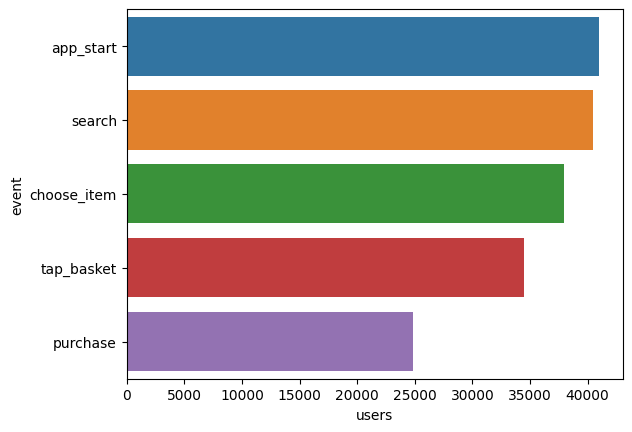

In [32]:
sns.barplot(data=d, x='users', y='event', hue='event')

__Ответ:__ Из графика четко видно, что наибольшее количество зарегистрированных пользователей отваливается на этапе перехода в корзину. То есть  конверсия из этого шага (в следующий шаг) самая низкая.

<h2>Задание 6<h2>

Пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?

Здесь будем считать __CR__ = кол-во юзеров, впервые совершивших покупку/кол-во юзеров, впервые открывших приложение 

In [33]:
# отбираем пользователей, открывших приложение
app_start_users = case_data.query("event == 'app_start' & utm_source != '-'") \
    .groupby("utm_source", as_index=False) \
    .agg({'device_id': 'nunique'})

In [34]:
# отбираем пользователей, совершивших покупку
purchase_users = case_data.query("event == 'purchase' & utm_source != '-'") \
    .groupby("utm_source", as_index=False) \
    .agg({'device_id': 'nunique'})

In [35]:
# объединяем их в одну таблицу
start_pur_users = app_start_users.merge(purchase_users, how='left', on='utm_source') \
    .rename(columns={"device_id_x": "app_start", "device_id_y": "purchase"})
start_pur_users

,utm_source,app_start,purchase
0,facebook_ads,25957,9017
1,google_ads,38092,11339
2,instagram_ads,31045,10762
3,referal,15924,6362
4,vk_ads,34079,12364
5,yandex-direct,40707,12028


In [36]:
# считаем CR
start_pur_users['CR, %'] = round(start_pur_users.purchase / start_pur_users.app_start * 100, 2)
start_pur_users.sort_values('CR, %')

,utm_source,app_start,purchase,"CR, %"
5,yandex-direct,40707,12028,29.55
1,google_ads,38092,11339,29.77
2,instagram_ads,31045,10762,34.67
0,facebook_ads,25957,9017,34.74
4,vk_ads,34079,12364,36.28
3,referal,15924,6362,39.95


__Ответ:__ Пользователи, пришедшие с Яндекс.Директ, показали самую низкую конверсию в первую покупку

<h2>Задание 7<h2>

Пользователи, пришедшие с какого канала, имеют медианный первый чек выше? 
(учитываются только первые покупки пользователей)

In [37]:
# отбираем покупки пользователей
purchases = case_data.query("event=='purchase'")[
    ['date', 'device_id', 'purchase_sum', 'utm_source']]

In [38]:
# оставляем только первые покупки
purchases = purchases.sort_values('date').drop_duplicates('device_id')
purchases

,date,device_id,purchase_sum,utm_source
7691,2020-01-01,6081155,265.5,-
8289,2020-01-01,1955306,292.0,yandex-direct
8290,2020-01-01,20176327,664.0,facebook_ads
8291,2020-01-01,28603960,337.0,-
8292,2020-01-01,14028316,502.0,referal
...,...,...,...,...
2506842,2020-03-31,32122725,670.0,-
2506845,2020-03-31,23188703,407.0,instagram_ads
2506848,2020-03-31,25732558,149.5,referal
2506852,2020-03-31,17778508,442.5,referal


In [39]:
# считаем медианный чек по каналам привлечения
purchases.query('utm_source!="-"')\
    .groupby('utm_source', as_index=False) \
    .agg({'purchase_sum': 'median'}) \
    .sort_values(by='purchase_sum', ascending=False)

,utm_source,purchase_sum
3,referal,395.5
2,instagram_ads,393.5
4,vk_ads,393.0
5,yandex-direct,392.5
1,google_ads,390.5
0,facebook_ads,389.0


__Ответ:__ Пользователи, пришедшие с Реферальной программы, имеют медианный первый чек выше

<h2>Задание 8<h2>

Данные по затратам на рекламу:

Яндекс – 10 491 707 руб.

Гугл – 10 534 878 руб.

Фейсбук – 8 590 498 руб.

Инстаграм – 8 561626 руб.

ВК – 9 553 531руб.

Какой платный канал привлечения (среди рекламных) имеет самый высокий __ROMI__?

In [40]:
# считаем выручку по каждому каналу привлечения
purch_facebook = case_data.query('utm_source=="facebook_ads"').agg({'purchase_sum':'sum'})

purch_google = case_data.query('utm_source=="google_ads"').agg({'purchase_sum':'sum'})

purch_instagram = case_data.query('utm_source=="instagram_ads"').agg({'purchase_sum':'sum'})

purch_vk = case_data.query('utm_source=="vk_ads"').agg({'purchase_sum':'sum'})

purch_yandex= case_data.query('utm_source=="yandex-direct"').agg({'purchase_sum':'sum'})

In [41]:
print('ROMI for facebook:',round((purch_facebook.iloc[0]-8590498)/8590498*100,2),'%') 
print('ROMI for google:',round((purch_google.iloc[0]-10534878 )/10534878*100,2),'%')
print('ROMI for instagram:',round((purch_instagram.iloc[0]-8561626)/8561626*100,2),'%')
print('ROMI for vk:',round((purch_vk.iloc[0]-9553531)/9553531*100,2),'%')
print('ROMI for yandex:',round((purch_yandex.iloc[0]-10491707)/10491707*100,2),'%')

ROMI for facebook: 42.6 %
ROMI for google: 22.15 %
ROMI for instagram: 69.91 %
ROMI for vk: 71.56 %
ROMI for yandex: 32.63 %


__Ответ:__ ВК имеет самый высокий __ROMI__